In [2]:
'''
Prepare parameters for model based on deisgn and measurement conditions
Unit: mm
Author: Yitian Shao
Created on 2022.01.17
'''
# %matplotlib notebook 
# %matplotlib notebook 

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

plt.rcParams.update({'font.size': 14})

from PouchLib import getEpsilon0 

try:
    EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity
except:
    EPSILON0 = 0.0000000000088541878128

calib = np.loadtxt('Calibration20210802.txt')
print("Calibration line a = %.16f, b = %.16f" % (calib[0],calib[1]))

Fs = 1000 # Sampling frequency of all measurements

c shared library imported successfully!
Calibration line a = 0.0497649079931161, b = 0.1217075926746309


In [3]:
'''
General Functions
'''

def aPlot(figName='', is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassFilter(datain, cutFreq, Fs, order):
    b, a = signal.butter(order, 2 * cutFreq / Fs, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeFileName(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    return condi, names, trialNum

def decodeFileName2(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    freq = None
    freqInfo = re.findall('[\.]*\dHz', names)
    if freqInfo:
        freq = float(re.split('Hz', freqInfo[0])[0])
        print("Signal frequency (Hz) = %.3f" % freq)
    
    return condi, names, trialNum, freq

''' Identify pressure increasing duration and compute time-averaged pressure '''
def processPressure(rawData, Fs, inactivePressure, cutOff=5, order=8):   
    print(rawData.shape)
    print(np.max(rawData))
    filtData = lowpassFilter(rawData, cutOff, Fs, order) - inactivePressure
        
    maxFiltPress = np.max(filtData) 
    print(maxFiltPress)
    
    samp = np.arange(len(rawData))
    ax0, _ = aPlot("Truncat")
    ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
    ax0.plot(samp, filtData, color='tab:blue')
    
    zipStart = samp[0]
    zipEnd = samp[-1]
    
    try:
        zipStart = np.nonzero(filtData > 0.25 * maxFiltPress)[0][0]
        ax0.plot([zipStart,zipStart], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the start of zipping process")

    try:
        zipEnd = np.argmax(filtData)
        ax0.plot([zipEnd,zipEnd], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the end of zipping process")
        
    plt.show()
    
    avgPressure = np.mean(rawData[zipStart:zipEnd+1] - inactivePressure)
    
    deltaT = (zipEnd - zipStart) / Fs
    
    maxPressure = rawData[zipEnd] - inactivePressure # Maximum steady state pressure
    peakPressure = np.max(rawData) - inactivePressure # Peak pressure reachable
    
    return avgPressure, deltaT, peakPressure, np.array([zipStart, zipEnd])


In [4]:
''' Condition table '''
# Layout: %d - number of dashes dividing rectangle column, T - extra triangle column, - R - an extra rectangle cell
colNames = ['CondiName','Shell','ls_um','Fluid','Infill_mL','DashLength_mm','FlatDashDist_mm','DashSpace_mm','Layout',
            'triNum','rectNum','TubeLength_mm','TubeInnerDia_mm','VoltPolar','Voltage_V','HVSupply','Info']
condiTable = [
    ['6mLBOPP12',           'BOPP',20,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLBOPP16',           'BOPP',20,'IC',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLL0Ws12SoftTube','PETL0Ws',30,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,4,'Uni',8800,'Wearable','20210719_SoftTube'],
    ['BOPP16ShiftedU7kV',   'BOPP',20,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210729_RigidTube'],
    ['L0Ws16ShiftedU9kV','PETL0Ws',30,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['L0Ws16NoShift',    'PETL0Ws',30,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['Mylar16',            'Mylar',15,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['Mylar16NoShift',     'Mylar',15,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16',              'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP20',              'BOPP',20,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16U9kV',          'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210728_RigidTube'],
    ['MLSi16SB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16S'],
    ['MLSi16CB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16C'],
    ['MLSi20SB7kV',  'Mylar',15,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_20S'],
    ['MLSi20B7kV',   'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube'],
    ['Tube6mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,35,6-2,'Bi',6900,'Wearable','20210924'],
    ['MedTubePressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['PressBalloon2',      'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['Tube8mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['Pressure',           'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['FR3Tube8mm',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20211008'],
    ['FR3MedTube',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['SiMedTube',    'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['L0WsSi5-20Trek8kV',      'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',8000,'Trek','20220302'],
    ['L0WsSi5-20Trek9kV',      'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi5-20Trek10kV',     'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi6-16Trek9kVHVTop', 'L0Ws',20,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi6-16Trek10kVHVTop','L0Ws',20,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi5-20sTrek9kVHVBot','L0Ws',20,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,4.0,'Bi',9000,'Trek','20220302'],
    ['MLSi20HV7kV.5Hz',       'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV1Hz',        'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402']
]
condiTable = pd.DataFrame(condiTable, columns = colNames)
condiTable.to_csv("ConditionTable.csv", index=False)

colNames2 = ['Material','DieConstant','DieStrength_V/um','Density_kg/m3','Viscosity_mm2/s']
materialProperty = [['BOPP',2.2,700,float('nan'),float('nan')],['Mylar',3.2,276,float('nan'),float('nan')],
                    ['L0Ws',3,float('nan'),float('nan'),float('nan')],
                    ['IC',3.2,20,920,34],['Silicone',2.6,15,920,5]]
materialProperty = pd.DataFrame(materialProperty, columns = colNames2)
materialProperty.to_csv("MaterialProperty.csv", index=False)

In [5]:
''' Design and zipping state '''
colNames3 = ['Layout','triNum','rectNum','triNum1Expan','rectNum1Expan','triNum2Expan','rectNum2Expan']

stateLayout = [
    ['6T5T4T3T2T1T', 48,27, -12,-6, -23,-12],
    ['5T4T3T2T1TRT', 36,21, -12,-6, -21,-11],
    ['T5T4T3T2T1', 45,20, -10,-5, -20,-10],
    ['T5T4T3T2T1TR', 48,21, -12,-6, -23,-11],
    ['5T4T3T2T1T', 37,20, -10,-5, -19,-10],
    ['T5T4T3T2T', 45,18, -10,-4, -19,-8]
]

stateLayout = pd.DataFrame(stateLayout, columns = colNames3)
stateLayout.to_csv("StateLayout.csv", index=False)


In [6]:
''' Generate model by matched parameters after getting model data of Valid Arc Length '''
md = pd.read_csv("./data/ValidArcLength.csv")
dataLen = md.shape[0]
print("Data contains %d rows" % dataLen)

''' Get total volume of design structures for inactive and zipped state '''
stateLayout = pd.read_csv("./data/StateLayout.csv")
stateLayout.head()

''' Compute total volume based on pouch design and zipping state '''
for layout_i in stateLayout['Layout']:
    ind = (stateLayout['Layout'] == layout_i)
    md[layout_i] = stateLayout.loc[ind,'triNum'].iloc[0] * md['triVol'] + stateLayout.loc[ind,'rectNum'].iloc[0] * md['rectVol']

# md.to_csv("ValidArcLength.csv", index=False)
md.head(1)    

Data contains 1914 rows


,dashHalfDist,dashSpace,R,triArc,triVol,rectVol,dashLength,6T5T4T3T2T1T,5T4T3T2T1TRT,T5T4T3T2T1,T5T4T3T2T1TR,5T4T3T2T1T,T5T4T3T2T
0,4.5,12.66,8.425705,9.999566,171.949277,138.938526,12.0,12004.905481,9107.883005,10516.487969,11171.274325,9140.893756,10238.610918


In [ ]:
'''Measurement 2022 Duel Trial'''
pressData = []
Fs = 1000
beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)

for root, directories, files in walk(".\data\DualTrial"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum = decodeFileName(fileName)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])

                for i in range(len(beginInd)): 
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                    P0 = data[beginInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa


Signal frequency (Hz) = 0.500
(8000,)
0.12446000650335837
0.12007833780744137


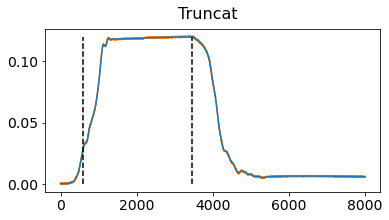


MLSi20HV7kV.5Hz - Trial22 - Seg1
Avg. Pressure of zipping = 0.109 (bar), Max. P. = 0.121 (bar) in 1.431 (sec)

(8000,)
0.14944696783709716
0.14506116317106163


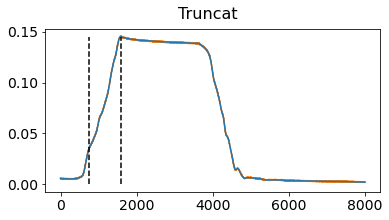


MLSi20HV7kV.5Hz - Trial22 - Seg2
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.146 (bar) in 0.414 (sec)

(8000,)
0.12207036771085061
0.11767098342917051


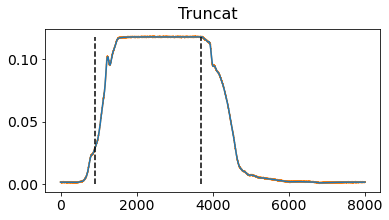


MLSi20HV7kV.5Hz - Trial22 - Seg3
Avg. Pressure of zipping = 0.109 (bar), Max. P. = 0.118 (bar) in 1.396 (sec)

(8000,)
0.11963261538560781
0.11529297737743628


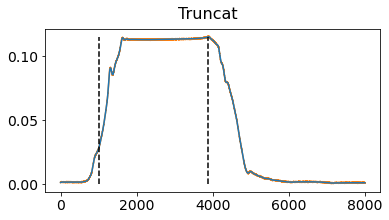


MLSi20HV7kV.5Hz - Trial22 - Seg4
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.116 (bar) in 1.436 (sec)

(8000,)
0.12361000075837239
0.11916084227680282


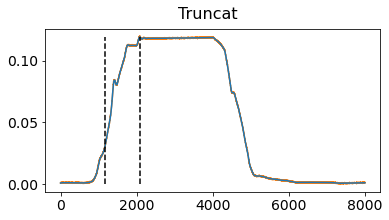


MLSi20HV7kV.5Hz - Trial22 - Seg5
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.120 (bar) in 0.462 (sec)

(8000,)
0.12130055118708973
0.11684144945042488


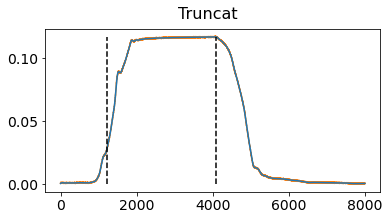


MLSi20HV7kV.5Hz - Trial22 - Seg6
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.117 (bar) in 1.426 (sec)

(8000,)
0.12017790208993843
0.1159012625637548


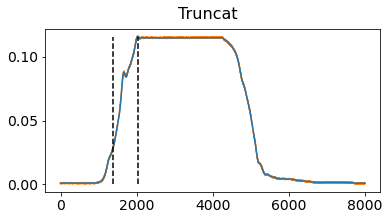


MLSi20HV7kV.5Hz - Trial22 - Seg7
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.116 (bar) in 0.323 (sec)

(8000,)
0.12250338950546612
0.11801175742599934


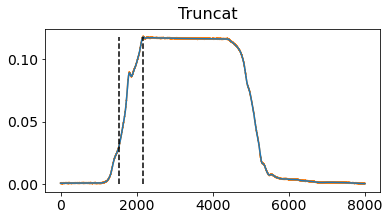


MLSi20HV7kV.5Hz - Trial22 - Seg8
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.119 (bar) in 0.323 (sec)

(8000,)
0.12128451334284471
0.1168938197086526


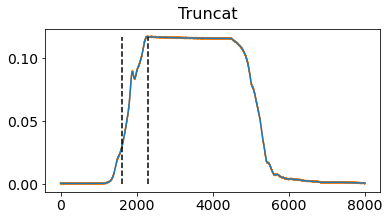


MLSi20HV7kV.5Hz - Trial22 - Seg9
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.117 (bar) in 0.340 (sec)

(8000,)
0.12224678399754582
0.11792903359711046


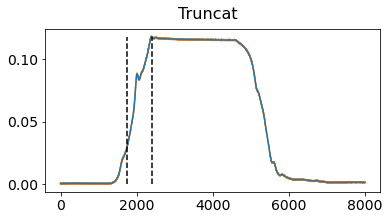


MLSi20HV7kV.5Hz - Trial22 - Seg10
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.118 (bar) in 0.326 (sec)

(8000,)
0.12325716818498199
0.11885295287888396


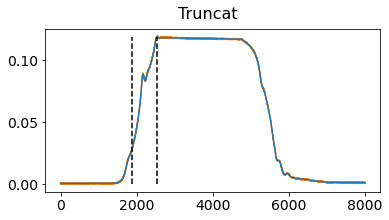


MLSi20HV7kV.5Hz - Trial22 - Seg11
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.119 (bar) in 0.326 (sec)

(8000,)
0.12150904316227497
0.11710085234107082


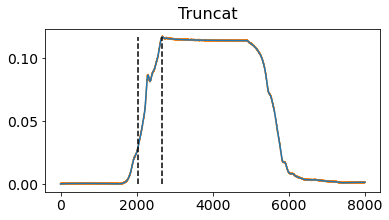


MLSi20HV7kV.5Hz - Trial22 - Seg12
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.118 (bar) in 0.321 (sec)

(8000,)
0.12447604434760338
0.12003593141028013


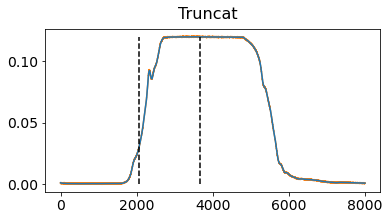


MLSi20HV7kV.5Hz - Trial22 - Seg13
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.121 (bar) in 0.799 (sec)

(8000,)
0.12256754088244619
0.1182349678949668


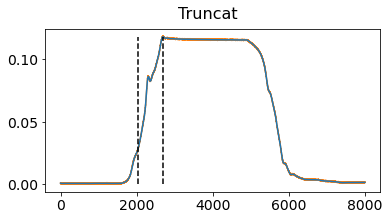


MLSi20HV7kV.5Hz - Trial22 - Seg14
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.119 (bar) in 0.323 (sec)

(8000,)
0.12460434710156354
0.12036458473884676


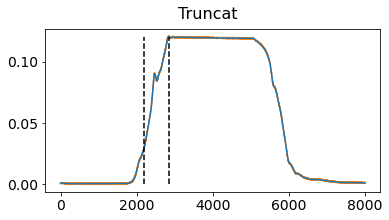


MLSi20HV7kV.5Hz - Trial22 - Seg15
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.121 (bar) in 0.323 (sec)

(8000,)
0.12336943309469711
0.11901233470506335


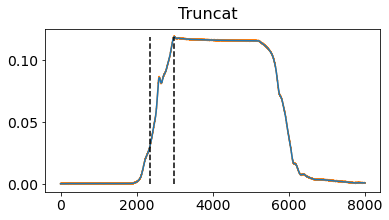


MLSi20HV7kV.5Hz - Trial22 - Seg16
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.119 (bar) in 0.324 (sec)

(8000,)
0.12250338950546612
0.11781583388433918


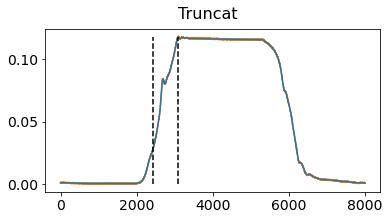


MLSi20HV7kV.5Hz - Trial22 - Seg17
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.119 (bar) in 0.327 (sec)

(5040,)
0.12470057416703365
0.12050025988113114


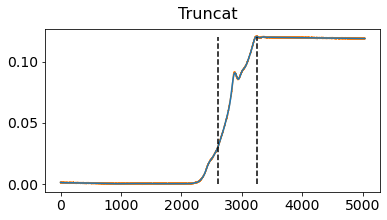


MLSi20HV7kV.5Hz - Trial22 - Seg18
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.121 (bar) in 0.321 (sec)

Signal frequency (Hz) = 0.500
(8000,)
0.11987318304928309
0.11570390725929416


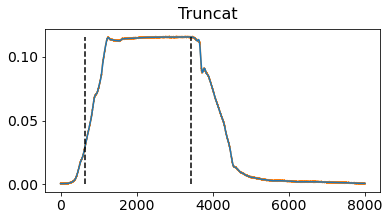


MLSi20HV7kV.5Hz - Trial23 - Seg1
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.116 (bar) in 1.399 (sec)

(8000,)
0.1357827245403414
0.13169286386901768


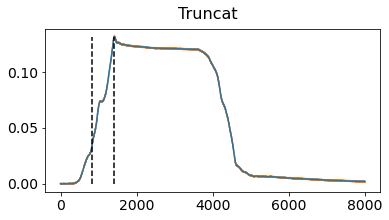


MLSi20HV7kV.5Hz - Trial23 - Seg2
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.132 (bar) in 0.297 (sec)

(8000,)
0.12282414639036648
0.11873650498766686


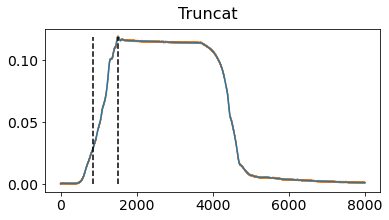


MLSi20HV7kV.5Hz - Trial23 - Seg3
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.119 (bar) in 0.327 (sec)

(8000,)
0.12117224843312958
0.11728122097496262


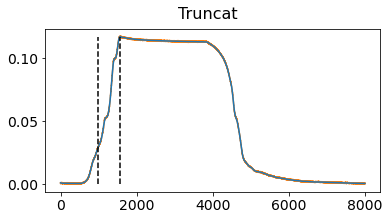


MLSi20HV7kV.5Hz - Trial23 - Seg4
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.118 (bar) in 0.291 (sec)

(8000,)
0.11735524150281519
0.11340557430249122


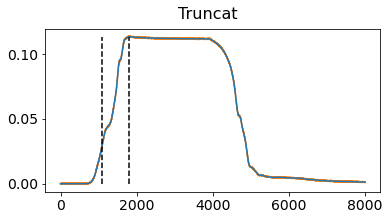


MLSi20HV7kV.5Hz - Trial23 - Seg5
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.114 (bar) in 0.359 (sec)

(8000,)
0.12059488604030892
0.1165646635784399


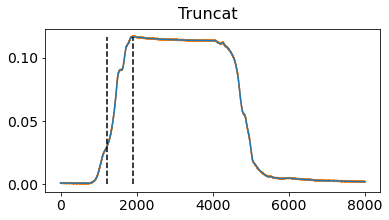


MLSi20HV7kV.5Hz - Trial23 - Seg6
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.117 (bar) in 0.342 (sec)

(8000,)
0.17034427888835624
0.1663364354235852


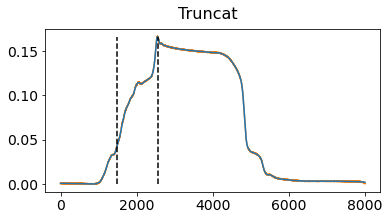


MLSi20HV7kV.5Hz - Trial23 - Seg7
Avg. Pressure of zipping = 0.103 (bar), Max. P. = 0.167 (bar) in 0.537 (sec)

(8000,)
0.09830228253973324
0.09429907508871728


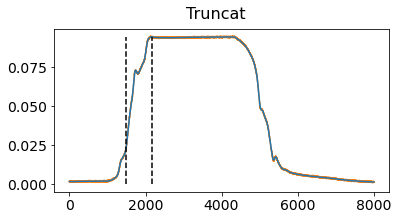


MLSi20HV7kV.5Hz - Trial23 - Seg8
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.095 (bar) in 0.334 (sec)

(8000,)
0.0987032286458587
0.09474380761509746


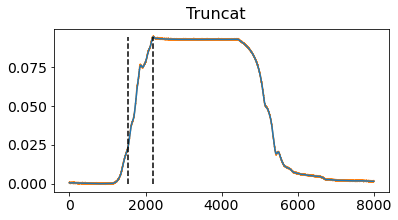


MLSi20HV7kV.5Hz - Trial23 - Seg9
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.095 (bar) in 0.332 (sec)

(8000,)
0.09118147969494504
0.08701042209586024


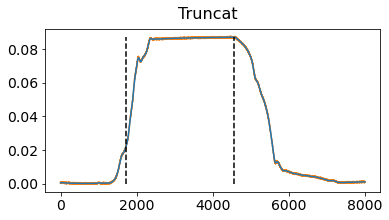


MLSi20HV7kV.5Hz - Trial23 - Seg10
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.088 (bar) in 1.427 (sec)

(8000,)
0.09876738002283877
0.09472970160777561


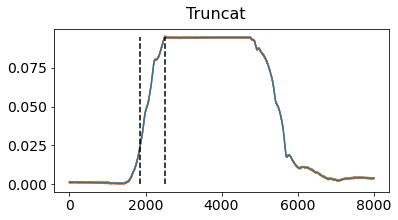


MLSi20HV7kV.5Hz - Trial23 - Seg11
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.095 (bar) in 0.337 (sec)

(8000,)
0.125005293207689
0.12113505316834608


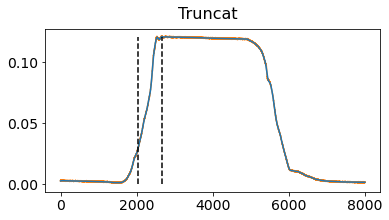


MLSi20HV7kV.5Hz - Trial23 - Seg12
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.121 (bar) in 0.309 (sec)

(8000,)
0.09551169764110003
0.09143559393000794


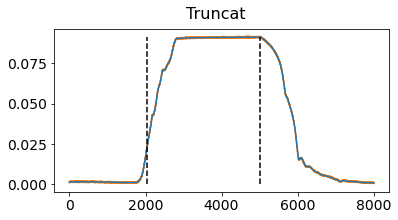


MLSi20HV7kV.5Hz - Trial23 - Seg13
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.092 (bar) in 1.479 (sec)

(8000,)
0.09997021834121517
0.09599491300543718


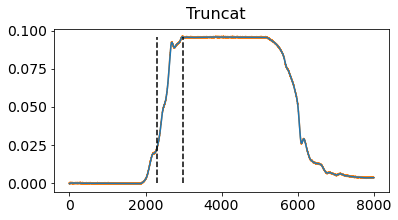


MLSi20HV7kV.5Hz - Trial23 - Seg14
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.096 (bar) in 0.331 (sec)

(8000,)
0.12008167502446833
0.11595388237261263


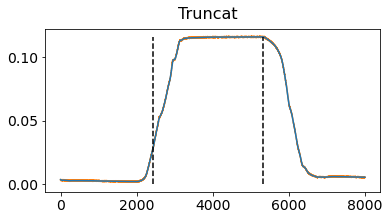


MLSi20HV7kV.5Hz - Trial23 - Seg15
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.117 (bar) in 1.440 (sec)

(8000,)
0.13852519590623957
0.13443261768063153


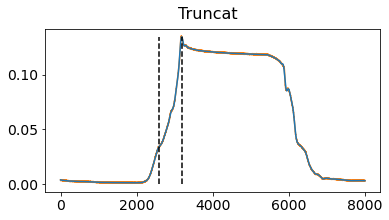


MLSi20HV7kV.5Hz - Trial23 - Seg16
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.135 (bar) in 0.304 (sec)

(8000,)
0.12694587236133623
0.12322697321701677


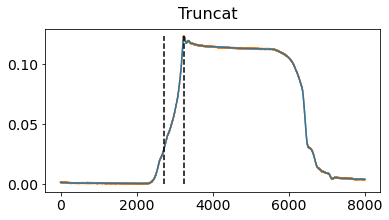


MLSi20HV7kV.5Hz - Trial23 - Seg17
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.123 (bar) in 0.259 (sec)

(8000,)
0.14859696209211118
0.14428645286686004


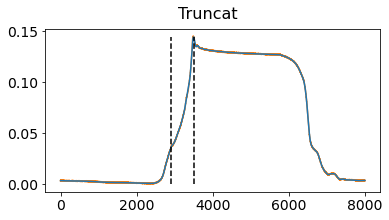


MLSi20HV7kV.5Hz - Trial23 - Seg18
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.145 (bar) in 0.295 (sec)

Signal frequency (Hz) = 0.500
(8000,)
0.16819520775952376
0.16566486284591436


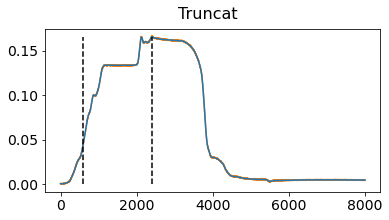


MLSi20HV7kV.5Hz - Trial24 - Seg1
Avg. Pressure of zipping = 0.126 (bar), Max. P. = 0.166 (bar) in 0.915 (sec)

(8000,)
0.09560792470657013
0.09323937697191785


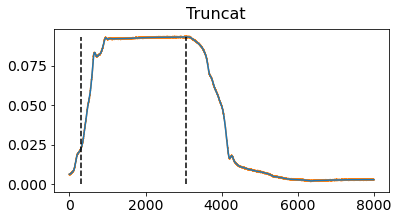


MLSi20HV7kV.5Hz - Trial24 - Seg2
Avg. Pressure of zipping = 0.087 (bar), Max. P. = 0.094 (bar) in 1.373 (sec)

(8000,)
0.09278526411944689
0.09035724757117514


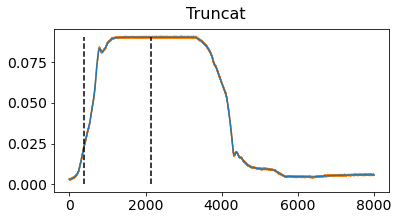


MLSi20HV7kV.5Hz - Trial24 - Seg3
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.091 (bar) in 0.879 (sec)

(8000,)
0.11785241467441077
0.11602771849664485


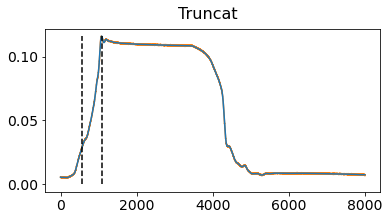


MLSi20HV7kV.5Hz - Trial24 - Seg4
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.116 (bar) in 0.258 (sec)

(8000,)
0.13743462249757832
0.13531050889612042


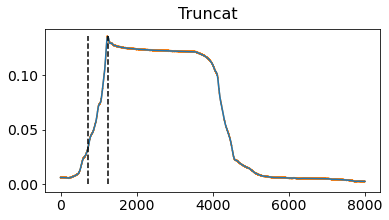


MLSi20HV7kV.5Hz - Trial24 - Seg5
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.136 (bar) in 0.258 (sec)

(8000,)
0.0847342663084476
0.08239196729288017


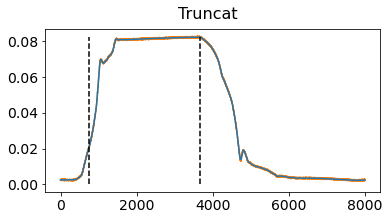


MLSi20HV7kV.5Hz - Trial24 - Seg6
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.083 (bar) in 1.458 (sec)

(8000,)
0.1036589225175694
0.10134753114741371


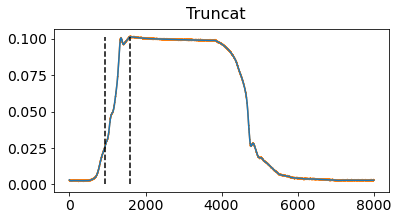


MLSi20HV7kV.5Hz - Trial24 - Seg7
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.102 (bar) in 0.338 (sec)

(8000,)
0.10835801088135982
0.10601274113075693


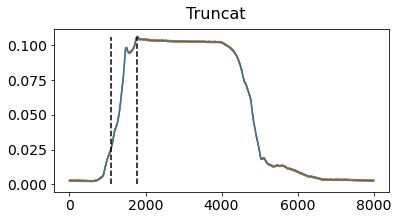


MLSi20HV7kV.5Hz - Trial24 - Seg8
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.107 (bar) in 0.340 (sec)

(8000,)
0.12290433561159159
0.12104749521347945


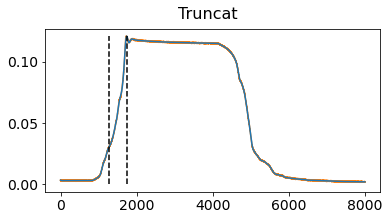


MLSi20HV7kV.5Hz - Trial24 - Seg9
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.121 (bar) in 0.235 (sec)

(8000,)
0.10430043628737015
0.10210841377412987


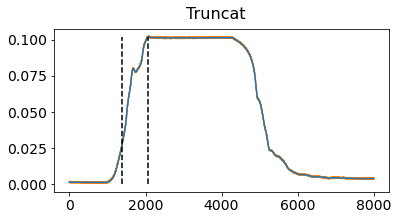


MLSi20HV7kV.5Hz - Trial24 - Seg10
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.102 (bar) in 0.354 (sec)

(8000,)
0.10181457042939228
0.09939595886404375


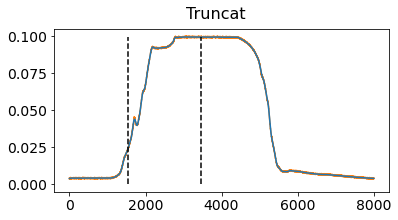


MLSi20HV7kV.5Hz - Trial24 - Seg11
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.100 (bar) in 0.954 (sec)

(8000,)
0.10285703030531848
0.1007797101060397


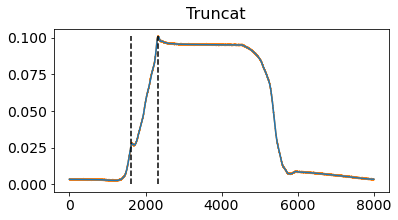


MLSi20HV7kV.5Hz - Trial24 - Seg12
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.101 (bar) in 0.361 (sec)

(8000,)
0.10335420347691406
0.1005173188929575


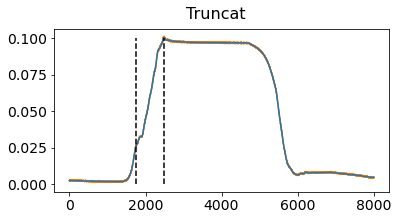


MLSi20HV7kV.5Hz - Trial24 - Seg13
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.102 (bar) in 0.376 (sec)

(8000,)
0.10142966216751184
0.09910622854127085


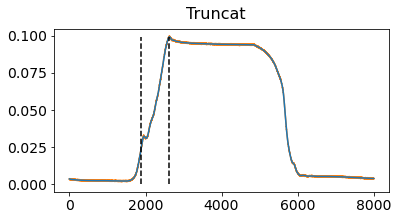


MLSi20HV7kV.5Hz - Trial24 - Seg14
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.100 (bar) in 0.368 (sec)

(8000,)
0.11557504079161814
0.11353099499103667


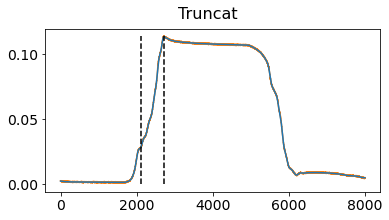


MLSi20HV7kV.5Hz - Trial24 - Seg15
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.114 (bar) in 0.305 (sec)

(8000,)
0.11976091813956796
0.11742750325346722


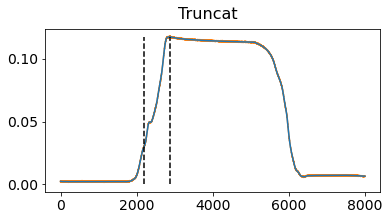


MLSi20HV7kV.5Hz - Trial24 - Seg16
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.118 (bar) in 0.345 (sec)

(8000,)
0.12073922663851408
0.11849318351590568


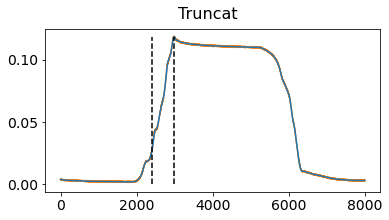


MLSi20HV7kV.5Hz - Trial24 - Seg17
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.119 (bar) in 0.285 (sec)

(8000,)
0.11847789059996648
0.11611258219269303


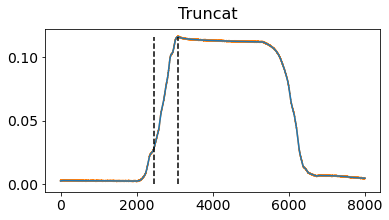


MLSi20HV7kV.5Hz - Trial24 - Seg18
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.117 (bar) in 0.317 (sec)

Signal frequency (Hz) = 0.500
(8000,)
0.11980903167230302
0.11688744102889517


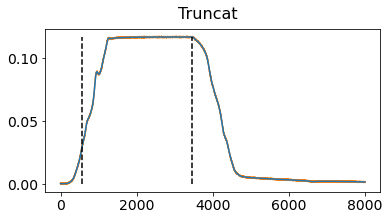


MLSi20HV7kV.5Hz - Trial25 - Seg1
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.118 (bar) in 1.445 (sec)

(8000,)
0.12373830351233255
0.12097538292113878


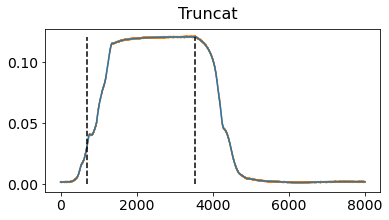


MLSi20HV7kV.5Hz - Trial25 - Seg2
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.121 (bar) in 1.421 (sec)

(8000,)
0.13164496072512666
0.12883444046402573


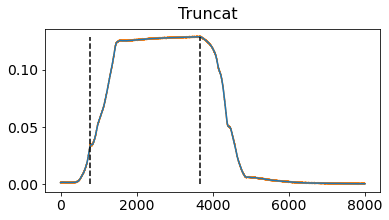


MLSi20HV7kV.5Hz - Trial25 - Seg3
Avg. Pressure of zipping = 0.114 (bar), Max. P. = 0.129 (bar) in 1.446 (sec)

(8000,)
0.12462038494580856
0.12174401648637505


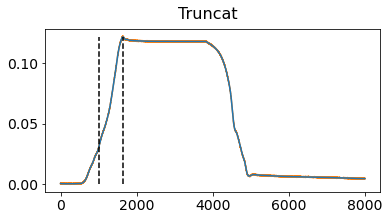


MLSi20HV7kV.5Hz - Trial25 - Seg4
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.122 (bar) in 0.316 (sec)

(8000,)
0.18084906686884333
0.17599459654159777


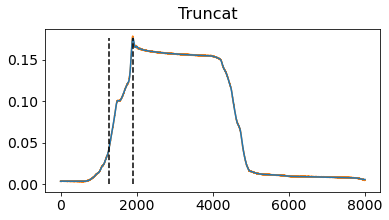


MLSi20HV7kV.5Hz - Trial25 - Seg5
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.179 (bar) in 0.312 (sec)

(8000,)
0.11095614164905282
0.10828569983118386


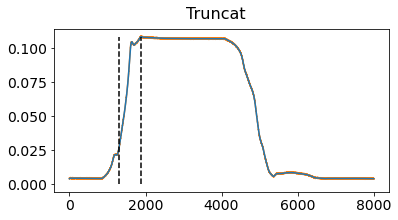


MLSi20HV7kV.5Hz - Trial25 - Seg6
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.109 (bar) in 0.292 (sec)

(8000,)
0.12332131956196206
0.12049292658487859


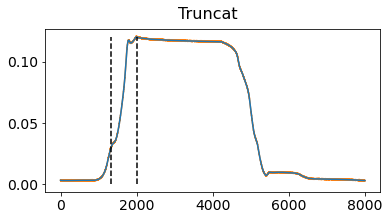


MLSi20HV7kV.5Hz - Trial25 - Seg7
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.121 (bar) in 0.336 (sec)

(8000,)
0.10685045352232808
0.1041109743446037


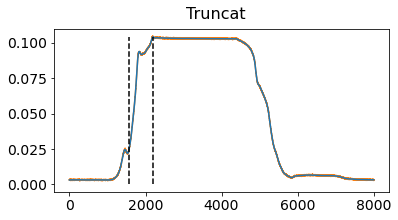


MLSi20HV7kV.5Hz - Trial25 - Seg8
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.105 (bar) in 0.310 (sec)

(8000,)
0.1046051553280255
0.10184955940073893


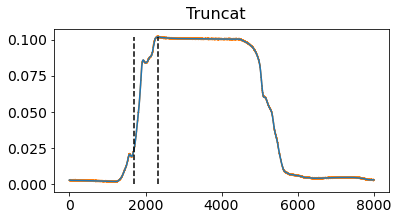


MLSi20HV7kV.5Hz - Trial25 - Seg9
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.102 (bar) in 0.314 (sec)

(8000,)
0.11138916344366831
0.10866050980477411


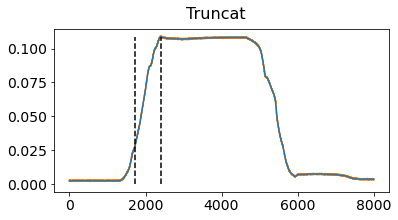


MLSi20HV7kV.5Hz - Trial25 - Seg10
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.109 (bar) in 0.345 (sec)

(8000,)
0.10609667484281221
0.10342656158161766


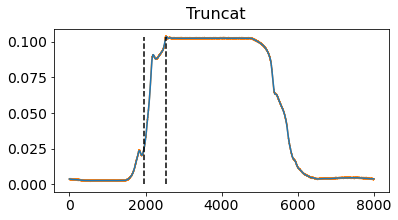


MLSi20HV7kV.5Hz - Trial25 - Seg11
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.104 (bar) in 0.291 (sec)

(8000,)
0.10446081472982033
0.10178449248317795


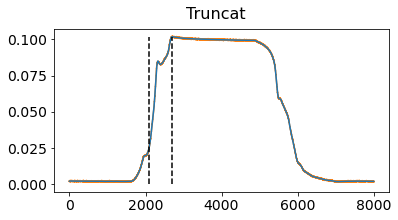


MLSi20HV7kV.5Hz - Trial25 - Seg12
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.102 (bar) in 0.302 (sec)

(8000,)
0.09977776421027494
0.09696844317709186


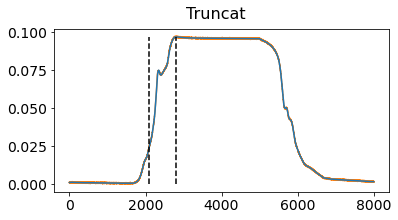


MLSi20HV7kV.5Hz - Trial25 - Seg13
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.098 (bar) in 0.357 (sec)

(8000,)
0.14136389433760785
0.13731153525218262


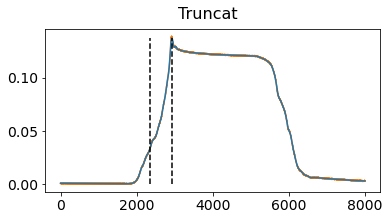


MLSi20HV7kV.5Hz - Trial25 - Seg14
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.139 (bar) in 0.284 (sec)

(8000,)
0.09899190984226904
0.096219819922959


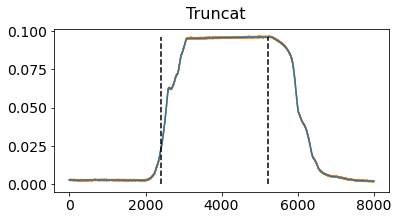


MLSi20HV7kV.5Hz - Trial25 - Seg15
Avg. Pressure of zipping = 0.089 (bar), Max. P. = 0.097 (bar) in 1.409 (sec)

(8000,)
0.09883153139981884
0.09606937105329823


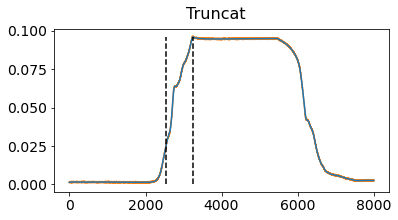


MLSi20HV7kV.5Hz - Trial25 - Seg16
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.097 (bar) in 0.360 (sec)

(8000,)
0.0960088708126956
0.09328295881892805


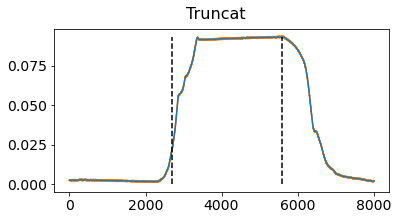


MLSi20HV7kV.5Hz - Trial25 - Seg17
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.094 (bar) in 1.444 (sec)

(8000,)
0.09889568277679892
0.09628603217668942


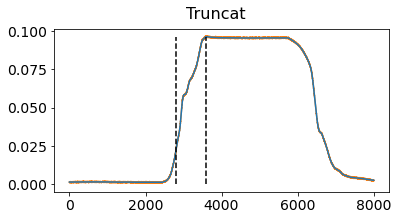


MLSi20HV7kV.5Hz - Trial25 - Seg18
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.097 (bar) in 0.395 (sec)

Signal frequency (Hz) = 1.000
(4000,)
0.132815723355013
0.13095043193886008


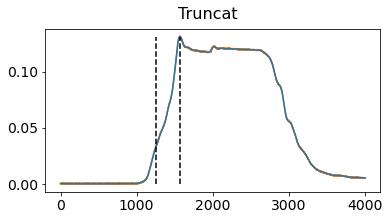


MLSi20HV7kV1Hz - Trial26 - Seg1
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.131 (bar) in 0.159 (sec)

(4000,)
0.11517409468549268
0.11321708904720114


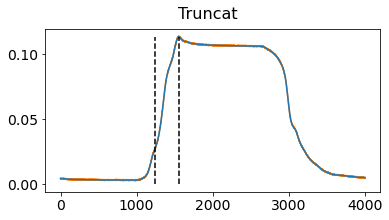


MLSi20HV7kV1Hz - Trial26 - Seg2
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.114 (bar) in 0.154 (sec)

(4000,)
0.11344200750703068
0.11112313643250418


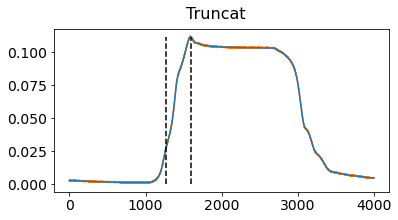


MLSi20HV7kV1Hz - Trial26 - Seg3
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.112 (bar) in 0.161 (sec)

(4000,)
0.1051183663438661
0.10332572400730441


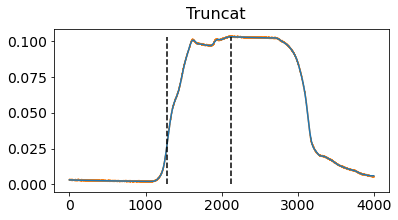


MLSi20HV7kV1Hz - Trial26 - Seg4
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.104 (bar) in 0.423 (sec)

(4000,)
0.10227966791249782
0.10028781737276643


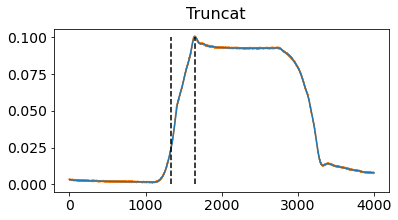


MLSi20HV7kV1Hz - Trial26 - Seg5
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.101 (bar) in 0.156 (sec)

(4000,)
0.1001787103164004
0.0983444168700958


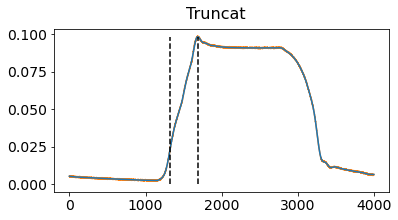


MLSi20HV7kV1Hz - Trial26 - Seg6
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.099 (bar) in 0.180 (sec)

(4000,)
0.098959834153779
0.09717301869906234


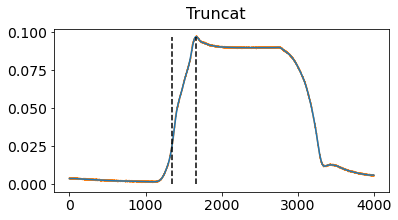


MLSi20HV7kV1Hz - Trial26 - Seg7
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.098 (bar) in 0.160 (sec)

(4000,)
0.09616924925514578
0.09448326291018186


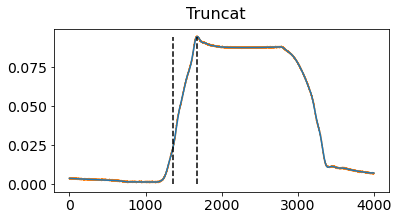


MLSi20HV7kV1Hz - Trial26 - Seg8
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.095 (bar) in 0.159 (sec)

(4000,)
0.092881491184917
0.09074157862164083


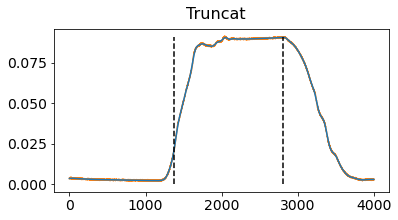


MLSi20HV7kV1Hz - Trial26 - Seg9
Avg. Pressure of zipping = 0.082 (bar), Max. P. = 0.091 (bar) in 0.715 (sec)

(4000,)
0.1060004477773421
0.1042487000195333


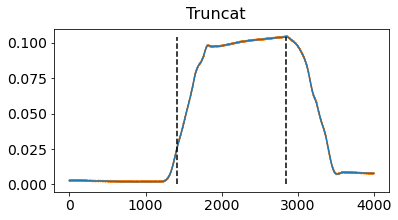


MLSi20HV7kV1Hz - Trial26 - Seg10
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.105 (bar) in 0.713 (sec)

(4000,)
0.13413082658310452
0.1317875240026687


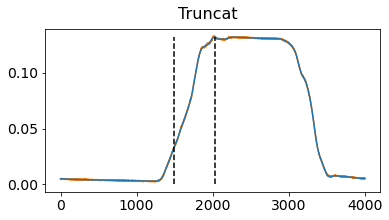


MLSi20HV7kV1Hz - Trial26 - Seg11
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.133 (bar) in 0.267 (sec)

(4000,)
0.12383453057780265
0.12201790497698002


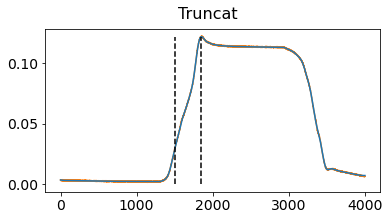


MLSi20HV7kV1Hz - Trial26 - Seg12
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.122 (bar) in 0.172 (sec)

(4000,)
0.11907129083703216
0.11680456682607158


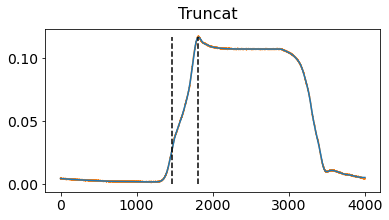


MLSi20HV7kV1Hz - Trial26 - Seg13
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.118 (bar) in 0.171 (sec)

(4000,)
0.11642504653660411
0.11425955815896345


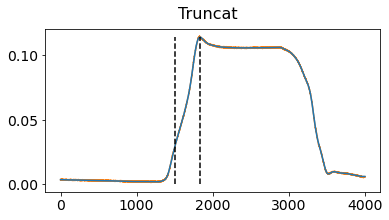


MLSi20HV7kV1Hz - Trial26 - Seg14
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.115 (bar) in 0.167 (sec)

(4000,)
0.11522220821822773
0.11300181051190299


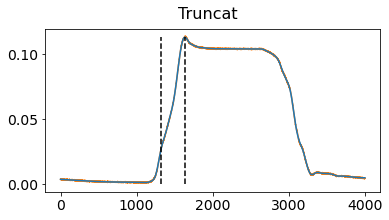


MLSi20HV7kV1Hz - Trial26 - Seg15
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.114 (bar) in 0.154 (sec)

(4000,)
0.11409955912107643
0.11174394818272128


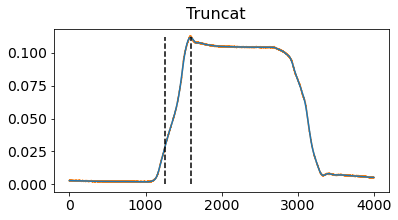


MLSi20HV7kV1Hz - Trial26 - Seg16
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.113 (bar) in 0.169 (sec)

(4000,)
0.1169382575524447
0.11443990152630769


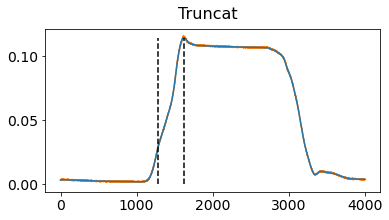


MLSi20HV7kV1Hz - Trial26 - Seg17
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.116 (bar) in 0.171 (sec)

(4000,)
0.12070715095002404
0.11843894650903408


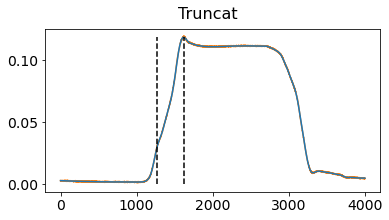


MLSi20HV7kV1Hz - Trial26 - Seg18
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.119 (bar) in 0.175 (sec)

Signal frequency (Hz) = 1.000
(4000,)
0.12340150878318715
0.11704431311507552


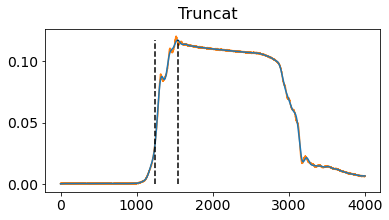


MLSi20HV7kV1Hz - Trial01 - Seg1
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.120 (bar) in 0.150 (sec)

(4000,)
0.11504579193153253
0.1107588282103302


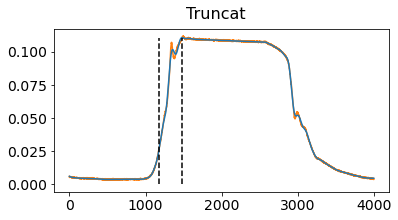


MLSi20HV7kV1Hz - Trial01 - Seg2
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.112 (bar) in 0.150 (sec)

(4000,)
0.12532605009258938
0.11854894348709495


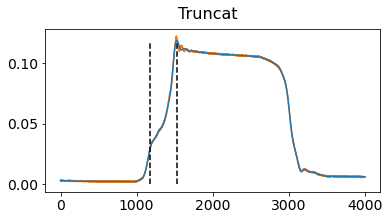


MLSi20HV7kV1Hz - Trial01 - Seg3
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.122 (bar) in 0.175 (sec)

(4000,)
0.1066098858586528
0.10062895394389286


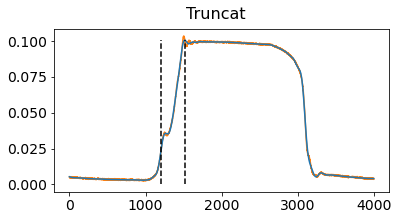


MLSi20HV7kV1Hz - Trial01 - Seg4
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.103 (bar) in 0.153 (sec)

(4000,)
0.10014663462791036
0.09512922346592112


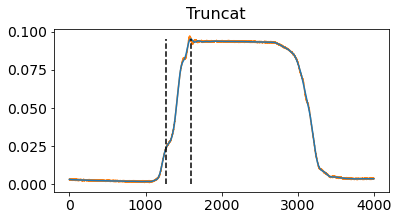


MLSi20HV7kV1Hz - Trial01 - Seg5
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.097 (bar) in 0.162 (sec)

(4000,)
0.1260477530836152
0.11771033706128799


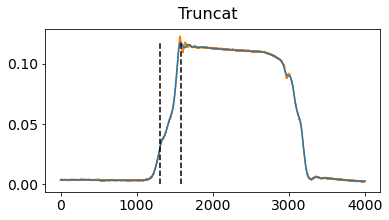


MLSi20HV7kV1Hz - Trial01 - Seg6
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.123 (bar) in 0.138 (sec)

(4000,)
0.1094646221342661
0.1052852360976398


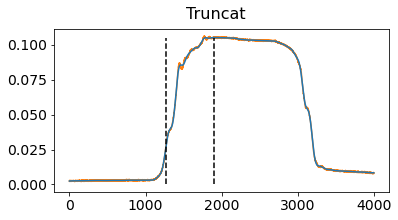


MLSi20HV7kV1Hz - Trial01 - Seg7
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.106 (bar) in 0.316 (sec)

(4000,)
0.11453258091569193
0.10612709469863621


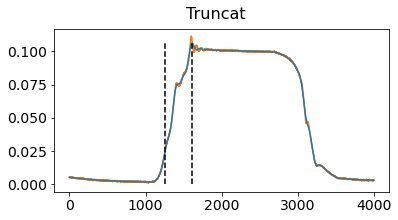


MLSi20HV7kV1Hz - Trial01 - Seg8
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.111 (bar) in 0.175 (sec)

(4000,)
0.10927216800332587
0.10429041933679704


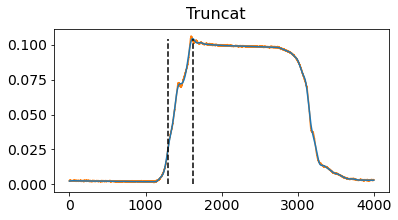


MLSi20HV7kV1Hz - Trial01 - Seg9
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.106 (bar) in 0.162 (sec)

(4000,)
0.10620893975252735
0.10179984073973218


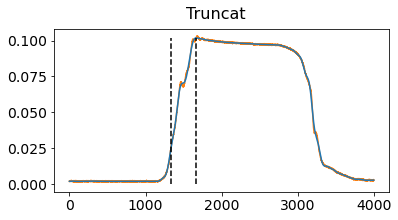


MLSi20HV7kV1Hz - Trial01 - Seg10
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.103 (bar) in 0.165 (sec)

(4000,)
0.10710705903024838
0.10197582705811876


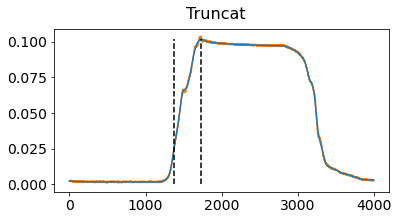


MLSi20HV7kV1Hz - Trial01 - Seg11
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.104 (bar) in 0.177 (sec)

(4000,)
0.10556742598272661
0.1007412402330455


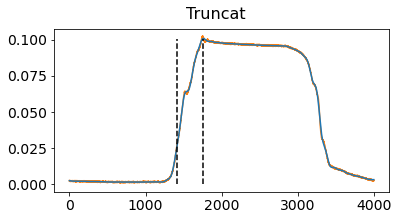


MLSi20HV7kV1Hz - Trial01 - Seg12
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.102 (bar) in 0.175 (sec)

(4000,)
0.10636931819497754
0.10146493544592784


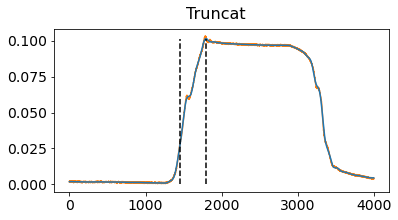


MLSi20HV7kV1Hz - Trial01 - Seg13
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.103 (bar) in 0.173 (sec)

(4000,)
0.10389949018124468
0.09999132146756566


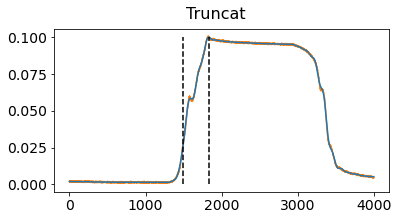


MLSi20HV7kV1Hz - Trial01 - Seg14
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.101 (bar) in 0.170 (sec)

(4000,)
0.10693064274355318
0.10303597724486288


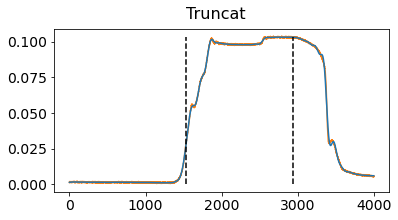


MLSi20HV7kV1Hz - Trial01 - Seg15
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.104 (bar) in 0.703 (sec)

(4000,)
0.11400333205560632
0.10710272669522948


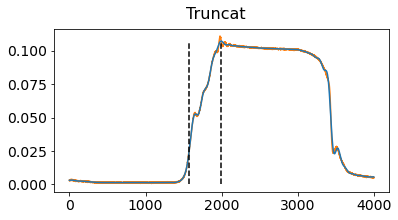


MLSi20HV7kV1Hz - Trial01 - Seg16
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.111 (bar) in 0.208 (sec)

(4000,)
0.1169382575524447
0.10876373265392644


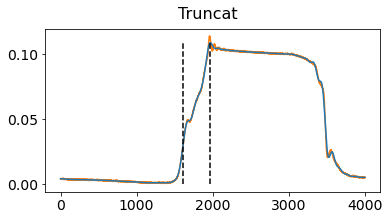


MLSi20HV7kV1Hz - Trial01 - Seg17
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.114 (bar) in 0.183 (sec)

(4000,)
0.11292879649119009
0.10438544292325184


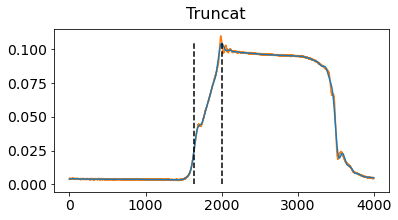


MLSi20HV7kV1Hz - Trial01 - Seg18
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.110 (bar) in 0.180 (sec)

Signal frequency (Hz) = 1.000
(4000,)
0.11583164629953843
0.1122567287617776


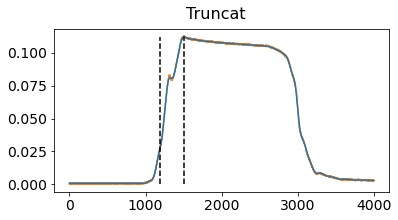


MLSi20HV7kV1Hz - Trial02 - Seg1
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.113 (bar) in 0.158 (sec)

(4000,)
0.11005802237133178
0.10557554317373773


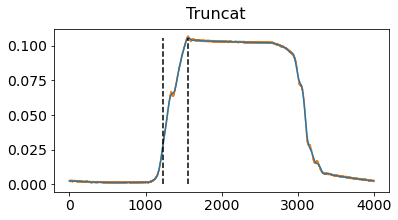


MLSi20HV7kV1Hz - Trial02 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.107 (bar) in 0.169 (sec)

(4000,)
0.11134104991093326
0.10696211396839912


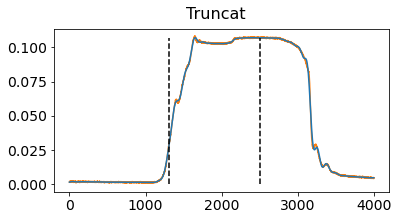


MLSi20HV7kV1Hz - Trial02 - Seg3
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.108 (bar) in 0.602 (sec)

(4000,)
0.11963261538560781
0.11382955825869219


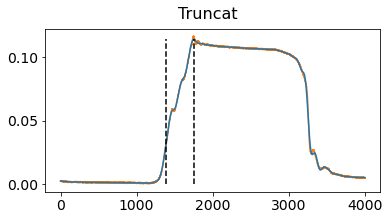


MLSi20HV7kV1Hz - Trial02 - Seg4
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.116 (bar) in 0.186 (sec)

(4000,)
0.12107602136765948
0.11267302519385458


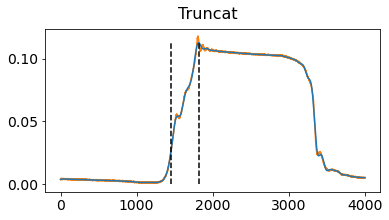


MLSi20HV7kV1Hz - Trial02 - Seg5
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.118 (bar) in 0.179 (sec)

(4000,)
0.11461277013691702
0.1062848696464248


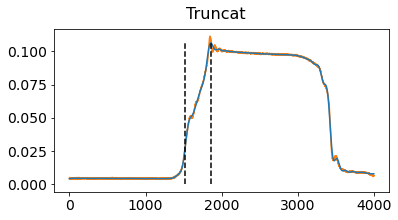


MLSi20HV7kV1Hz - Trial02 - Seg6
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.111 (bar) in 0.170 (sec)

(4000,)
0.11102029302603289
0.10469256866210001


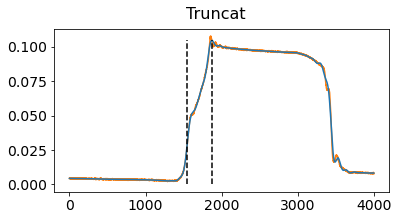


MLSi20HV7kV1Hz - Trial02 - Seg7
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.108 (bar) in 0.165 (sec)

(4000,)
0.1098976439288816
0.10470912626717067


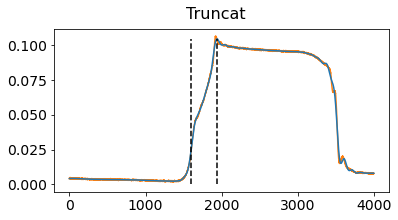


MLSi20HV7kV1Hz - Trial02 - Seg8
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.107 (bar) in 0.169 (sec)

(4000,)
0.1083419730371148
0.10397997321888479


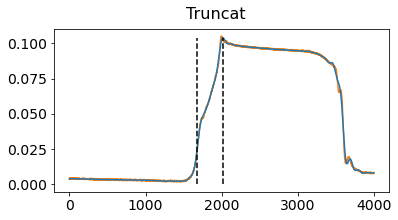


MLSi20HV7kV1Hz - Trial02 - Seg9
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.105 (bar) in 0.168 (sec)

(4000,)
0.10709102118600336
0.1032271530359746


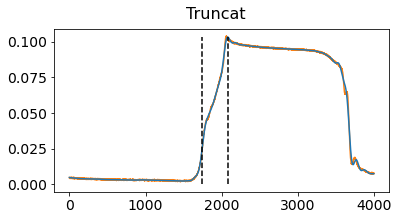


MLSi20HV7kV1Hz - Trial02 - Seg10
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.104 (bar) in 0.167 (sec)

(4000,)
0.10442873904133029
0.10159490854117206


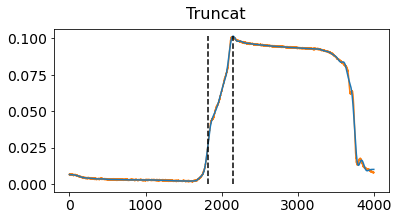


MLSi20HV7kV1Hz - Trial02 - Seg11
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.167 (sec)

(4000,)
0.10107682959412144
0.09852923999714085


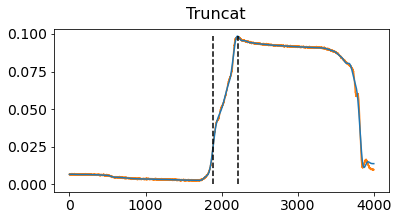


MLSi20HV7kV1Hz - Trial02 - Seg12
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.098 (bar) in 0.162 (sec)

(4000,)
0.10199098671608749
0.09656505057179757


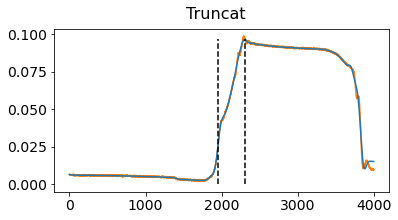


MLSi20HV7kV1Hz - Trial02 - Seg13
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.099 (bar) in 0.178 (sec)

(4000,)
0.10420420922190003
0.09798052516524683


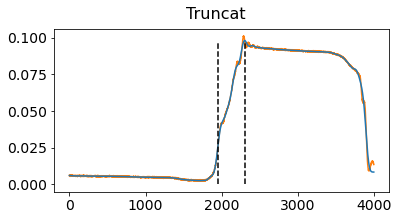


MLSi20HV7kV1Hz - Trial02 - Seg14
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.177 (sec)

(4000,)
0.10418817137765501
0.09752646239068259


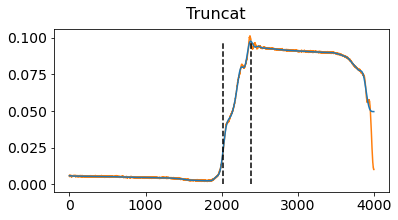


MLSi20HV7kV1Hz - Trial02 - Seg15
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.179 (sec)

(4000,)
0.10442873904133029
0.0980814173829261


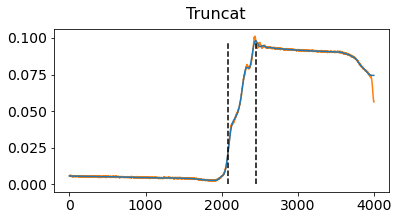


MLSi20HV7kV1Hz - Trial02 - Seg16
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.178 (sec)

(4000,)
0.10369099820605944
0.09762227478893794


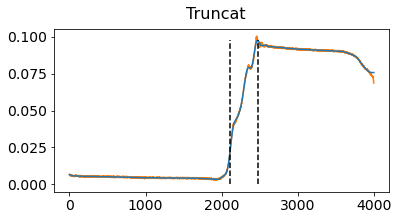


MLSi20HV7kV1Hz - Trial02 - Seg17
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.100 (bar) in 0.178 (sec)

(4000,)
0.10157400276571701
0.09625607997275204


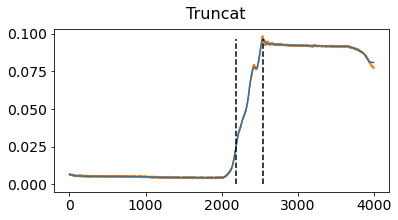


MLSi20HV7kV1Hz - Trial02 - Seg18
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.098 (bar) in 0.180 (sec)

Signal frequency (Hz) = 0.500
(8000,)
0.1125920017620447
0.10951483268523778


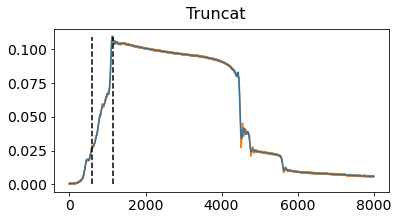


MLSi20HV7kV.5Hz - Trial03 - Seg1
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.110 (bar) in 0.270 (sec)

(8000,)
0.1106033090756624
0.09963465120763591


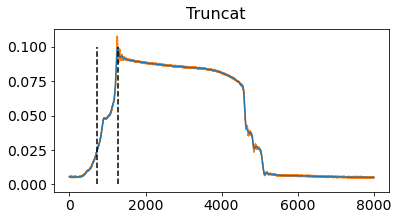


MLSi20HV7kV.5Hz - Trial03 - Seg2
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.108 (bar) in 0.270 (sec)

(8000,)
0.100707959176486
0.09076693070389388


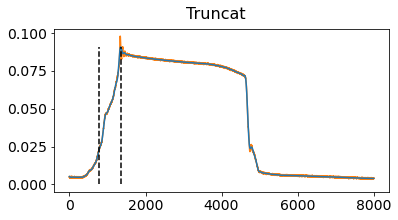


MLSi20HV7kV.5Hz - Trial03 - Seg3
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.098 (bar) in 0.284 (sec)

(8000,)
0.09049185239240924
0.08330035188711427


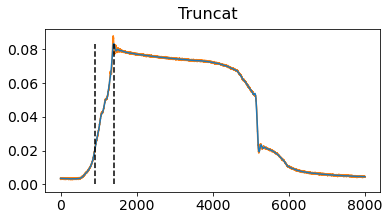


MLSi20HV7kV.5Hz - Trial03 - Seg4
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.088 (bar) in 0.247 (sec)

(8000,)
0.08114178919756347
0.07190839043182372


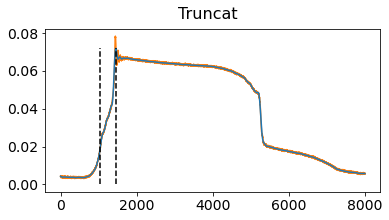


MLSi20HV7kV.5Hz - Trial03 - Seg5
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.078 (bar) in 0.209 (sec)

(8000,)
0.0669322591964771
0.06157577527395472


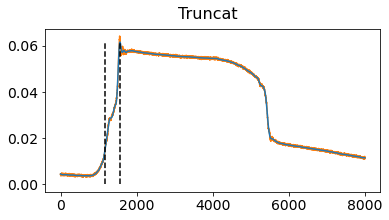


MLSi20HV7kV.5Hz - Trial03 - Seg6
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.064 (bar) in 0.195 (sec)

(8000,)
0.05580199529043428
0.050662115711225496


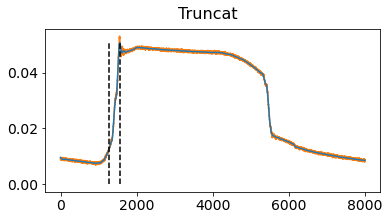


MLSi20HV7kV.5Hz - Trial03 - Seg7
Avg. Pressure of zipping = 0.027 (bar), Max. P. = 0.053 (bar) in 0.141 (sec)

(8000,)
0.04864911675715604
0.042551189751479


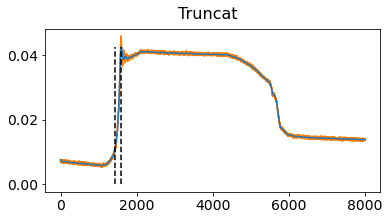


MLSi20HV7kV.5Hz - Trial03 - Seg8
Avg. Pressure of zipping = 0.024 (bar), Max. P. = 0.046 (bar) in 0.085 (sec)

(8000,)
0.04528116946570216
0.04184996746225071


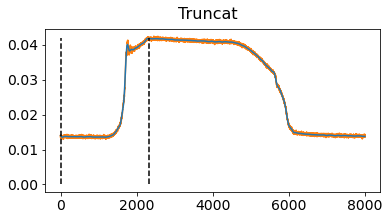


MLSi20HV7kV.5Hz - Trial03 - Seg9
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.157 (sec)

(8000,)
0.0459226832355029
0.04233929889206329


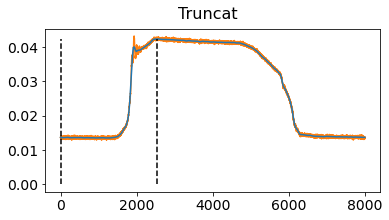


MLSi20HV7kV.5Hz - Trial03 - Seg10
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.272 (sec)

(8000,)
0.04598683461248297
0.04258645327089525


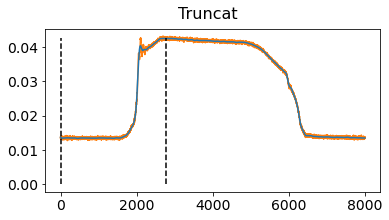


MLSi20HV7kV.5Hz - Trial03 - Seg11
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.387 (sec)

(8000,)
0.04704533233265419
0.04300615763802495


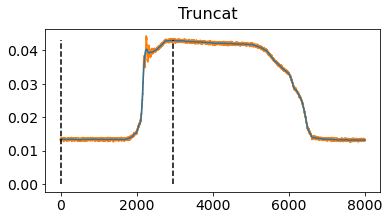


MLSi20HV7kV.5Hz - Trial03 - Seg12
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.044 (bar) in 1.478 (sec)

(8000,)
0.04651608347256858
0.043110650686235645


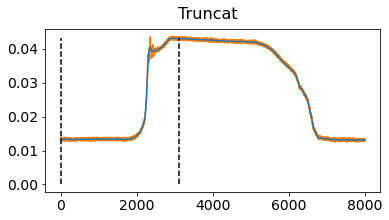


MLSi20HV7kV.5Hz - Trial03 - Seg13
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.044 (bar) in 1.558 (sec)

(8000,)
0.04717363508661434
0.04328244492753876


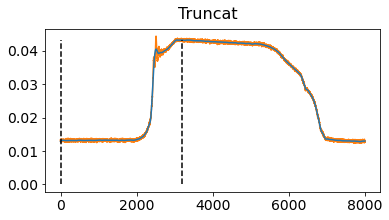


MLSi20HV7kV.5Hz - Trial03 - Seg14
Avg. Pressure of zipping = 0.020 (bar), Max. P. = 0.044 (bar) in 1.591 (sec)

(8000,)
0.04691702957869404
0.04344584310543774


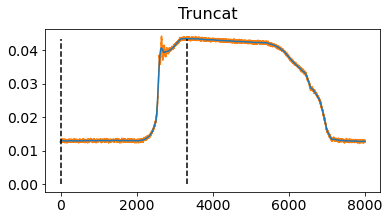


MLSi20HV7kV.5Hz - Trial03 - Seg15
Avg. Pressure of zipping = 0.020 (bar), Max. P. = 0.044 (bar) in 1.667 (sec)

(8000,)
0.04771892179094497
0.04352420476434952


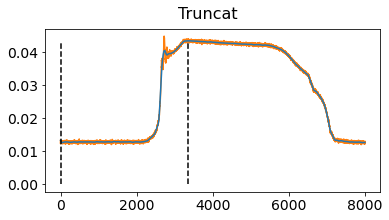


MLSi20HV7kV.5Hz - Trial03 - Seg16
Avg. Pressure of zipping = 0.019 (bar), Max. P. = 0.045 (bar) in 1.671 (sec)

(8000,)
0.04770288394669995
0.0436178848486804


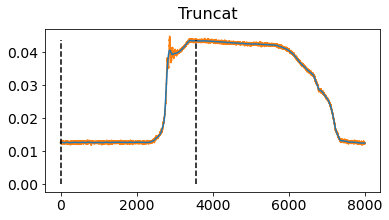


MLSi20HV7kV.5Hz - Trial03 - Seg17
Avg. Pressure of zipping = 0.019 (bar), Max. P. = 0.045 (bar) in 1.778 (sec)

(8000,)
0.04751042981575973
0.043490227052729695


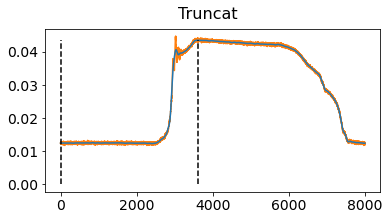


MLSi20HV7kV.5Hz - Trial03 - Seg18
Avg. Pressure of zipping = 0.018 (bar), Max. P. = 0.045 (bar) in 1.805 (sec)

Signal frequency (Hz) = 1.000
(4000,)
0.08197575709830443
0.07181881234043523


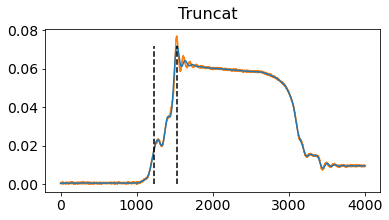


MLSi20HV7kV1Hz - Trial04 - Seg1
Avg. Pressure of zipping = 0.034 (bar), Max. P. = 0.077 (bar) in 0.150 (sec)

(4000,)
0.06625866973818632
0.060109616811851965


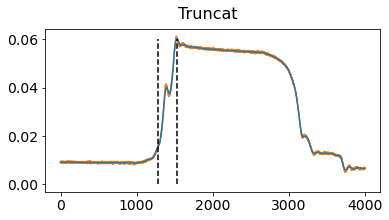


MLSi20HV7kV1Hz - Trial04 - Seg2
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.061 (bar) in 0.128 (sec)

(4000,)
0.06425393920755902
0.057765802093715415


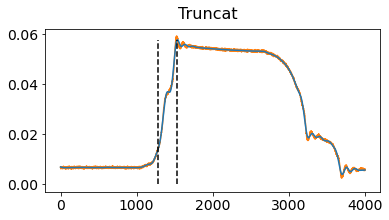


MLSi20HV7kV1Hz - Trial04 - Seg3
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.059 (bar) in 0.125 (sec)

(4000,)
0.06095014329308521
0.05442694816187478


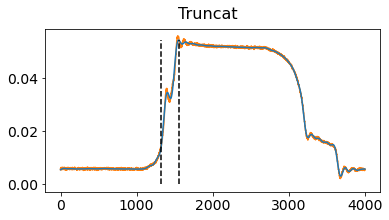


MLSi20HV7kV1Hz - Trial04 - Seg4
Avg. Pressure of zipping = 0.035 (bar), Max. P. = 0.056 (bar) in 0.116 (sec)

(4000,)
0.05740577971493613
0.05218521663795807


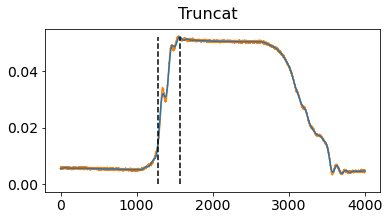


MLSi20HV7kV1Hz - Trial04 - Seg5
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.052 (bar) in 0.144 (sec)

(4000,)
0.05771049875559148
0.05232891744077375


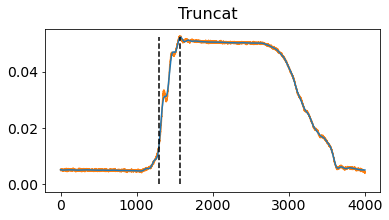


MLSi20HV7kV1Hz - Trial04 - Seg6
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.142 (sec)

(4000,)
0.05493595170120328
0.04985397799214013


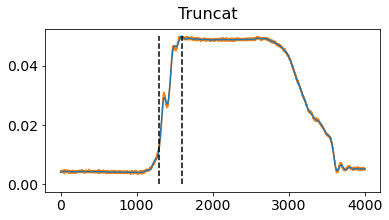


MLSi20HV7kV1Hz - Trial04 - Seg7
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.050 (bar) in 0.147 (sec)

(4000,)
0.056555773969950145
0.051730494972524285


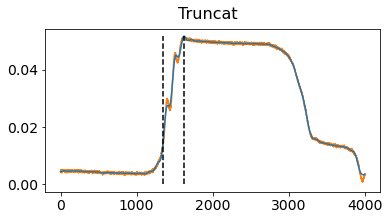


MLSi20HV7kV1Hz - Trial04 - Seg8
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.052 (bar) in 0.141 (sec)

(4000,)
0.057534082468896276
0.05124888755870119


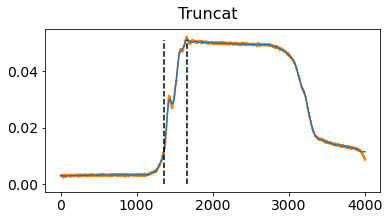


MLSi20HV7kV1Hz - Trial04 - Seg9
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.052 (bar) in 0.150 (sec)

(4000,)
0.05758219600163133
0.05156934360579177


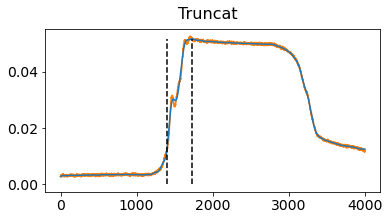


MLSi20HV7kV1Hz - Trial04 - Seg10
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.165 (sec)

(4000,)
0.05820767192718705
0.05178462058192225


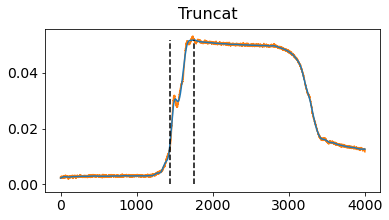


MLSi20HV7kV1Hz - Trial04 - Seg11
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.160 (sec)

(4000,)
0.05886522354123281
0.05236713820730811


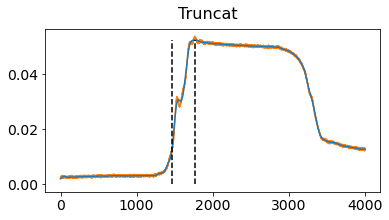


MLSi20HV7kV1Hz - Trial04 - Seg12
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.054 (bar) in 0.151 (sec)

(4000,)
0.05899352629519296
0.052662934127296335


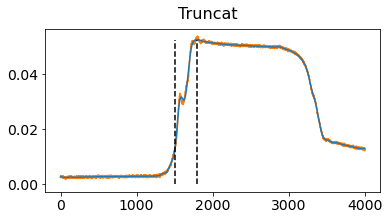


MLSi20HV7kV1Hz - Trial04 - Seg13
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.054 (bar) in 0.147 (sec)

(4000,)
0.0587689964757627
0.05288771276726702


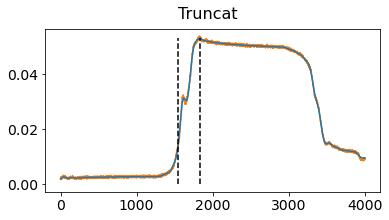


MLSi20HV7kV1Hz - Trial04 - Seg14
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.054 (bar) in 0.145 (sec)

(4000,)
0.05775861228832654
0.05266354995458826


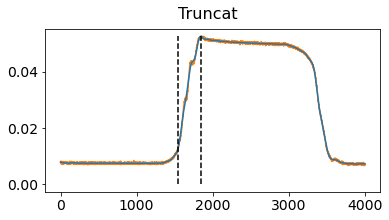


MLSi20HV7kV1Hz - Trial04 - Seg15
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.146 (sec)

(4000,)
0.05852842881208742
0.052926967200010694


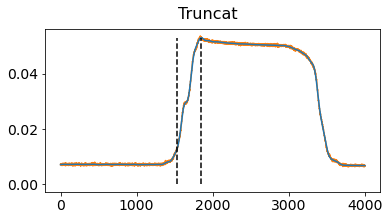


MLSi20HV7kV1Hz - Trial04 - Seg16
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.157 (sec)

(4000,)
0.058303898992657165
0.052795161186845005


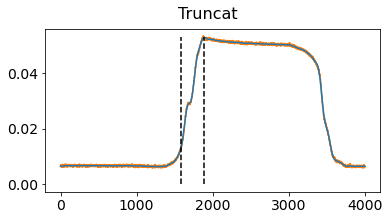


MLSi20HV7kV1Hz - Trial04 - Seg17
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.153 (sec)

(4000,)
0.05862465587755753
0.05273979502072888


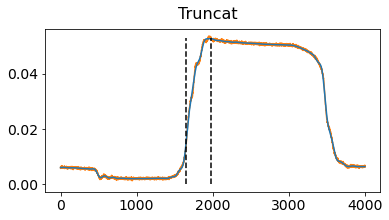


MLSi20HV7kV1Hz - Trial04 - Seg18
Avg. Pressure of zipping = 0.041 (bar), Max. P. = 0.054 (bar) in 0.165 (sec)

Signal frequency (Hz) = 1.000
(4000,)
0.1111967093127281
0.10774475225870506


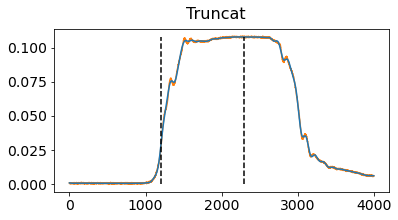


MLSi20HV7kV1Hz - Trial05 - Seg1
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.108 (bar) in 0.545 (sec)

(4000,)
0.11785241467441077
0.1133599329607317


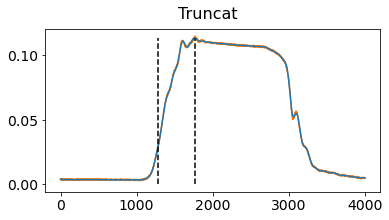


MLSi20HV7kV1Hz - Trial05 - Seg2
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.115 (bar) in 0.242 (sec)

(4000,)
0.11045896847745725
0.10680806927924807


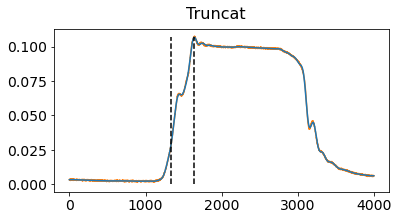


MLSi20HV7kV1Hz - Trial05 - Seg3
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.108 (bar) in 0.156 (sec)

(4000,)
0.08373991996525647
0.0805028661309897


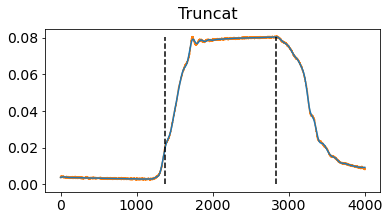


MLSi20HV7kV1Hz - Trial05 - Seg4
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.081 (bar) in 0.726 (sec)

(4000,)
0.08502294750485793
0.08145624773294162


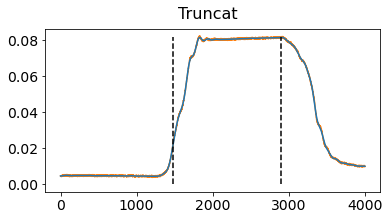


MLSi20HV7kV1Hz - Trial05 - Seg5
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.082 (bar) in 0.716 (sec)

(4000,)
0.08968996018015832
0.08533078054203845


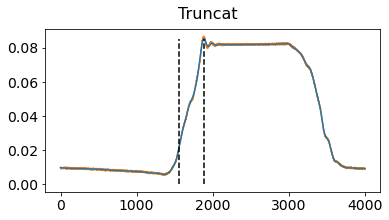


MLSi20HV7kV1Hz - Trial05 - Seg6
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.087 (bar) in 0.164 (sec)

(4000,)
0.09066826867910445
0.08641204464446733


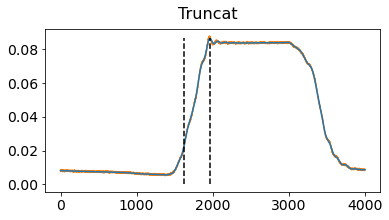


MLSi20HV7kV1Hz - Trial05 - Seg7
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.088 (bar) in 0.172 (sec)

(4000,)
0.09260884783275168
0.0886420819135687


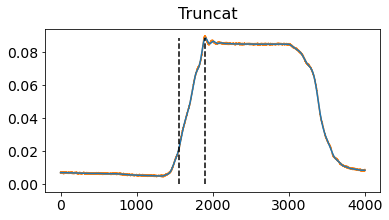


MLSi20HV7kV1Hz - Trial05 - Seg8
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.090 (bar) in 0.173 (sec)

(4000,)
0.09472584327309412
0.09082091262292585


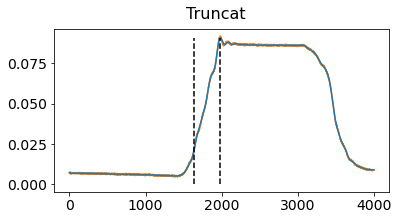


MLSi20HV7kV1Hz - Trial05 - Seg9
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.092 (bar) in 0.171 (sec)

(4000,)
0.09634566554184099
0.09236402713973743


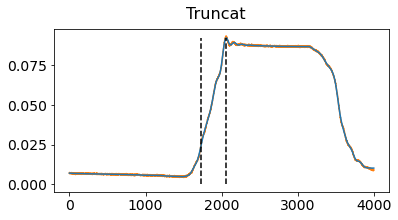


MLSi20HV7kV1Hz - Trial05 - Seg10
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.093 (bar) in 0.169 (sec)

(4000,)
0.09620132494363581
0.09227053808743928


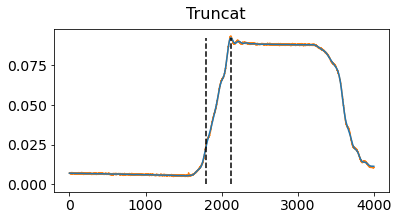


MLSi20HV7kV1Hz - Trial05 - Seg11
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.093 (bar) in 0.165 (sec)

(4000,)
0.10022682384913545
0.09597054825478574


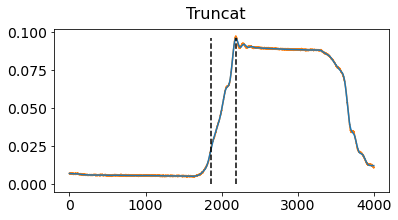


MLSi20HV7kV1Hz - Trial05 - Seg12
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.097 (bar) in 0.162 (sec)

(4000,)
0.10215136515853768
0.09746746955362637


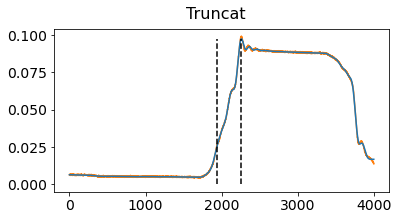


MLSi20HV7kV1Hz - Trial05 - Seg13
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.099 (bar) in 0.163 (sec)

(4000,)
0.0955758490180801
0.09130919983428391


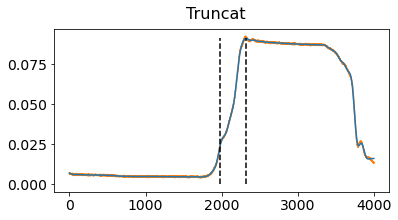


MLSi20HV7kV1Hz - Trial05 - Seg14
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.093 (bar) in 0.173 (sec)

(4000,)
0.09843058529369339
0.09415140502071276


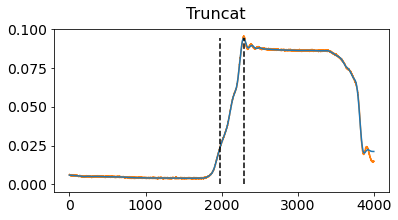


MLSi20HV7kV1Hz - Trial05 - Seg15
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.096 (bar) in 0.157 (sec)

(4000,)
0.09677868733645649
0.09269858098434494


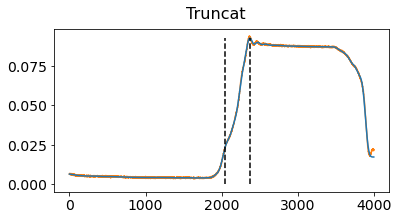


MLSi20HV7kV1Hz - Trial05 - Seg16
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.094 (bar) in 0.164 (sec)

(4000,)
0.09676264949221146
0.09304483136133464


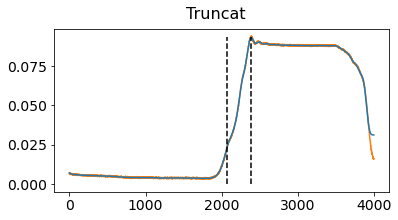


MLSi20HV7kV1Hz - Trial05 - Seg17
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.094 (bar) in 0.160 (sec)

(4000,)
0.09642585476306607
0.09232407023972466


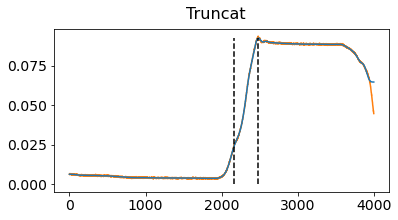


MLSi20HV7kV1Hz - Trial05 - Seg18
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.094 (bar) in 0.163 (sec)

Signal frequency (Hz) = 1.000
(4000,)
0.12524586087136427
0.11440428723153827


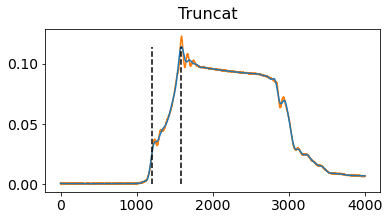


MLSi20HV7kV1Hz - Trial06 - Seg1
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.123 (bar) in 0.191 (sec)

(4000,)
0.13121193893051114
0.12461767677163077


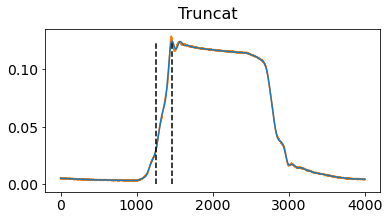


MLSi20HV7kV1Hz - Trial06 - Seg2
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.129 (bar) in 0.104 (sec)

(4000,)
0.09358715633169781
0.09012976923208933


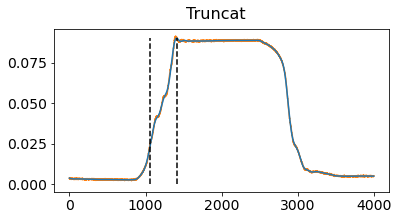


MLSi20HV7kV1Hz - Trial06 - Seg3
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.091 (bar) in 0.176 (sec)

(4000,)
0.09820605547426313
0.095520742951303


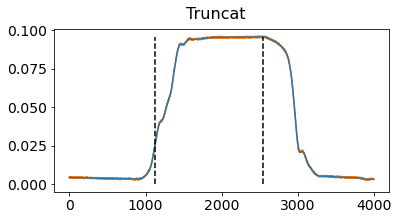


MLSi20HV7kV1Hz - Trial06 - Seg4
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.096 (bar) in 0.711 (sec)

(4000,)
0.11127689853395319
0.10868779064033898


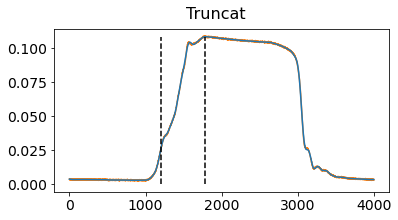


MLSi20HV7kV1Hz - Trial06 - Seg5
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.109 (bar) in 0.289 (sec)

(4000,)
0.1250854824289141
0.11749015725549229


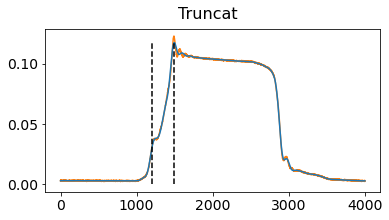


MLSi20HV7kV1Hz - Trial06 - Seg6
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.123 (bar) in 0.148 (sec)

(4000,)
0.12696191020558126
0.11752213081211357


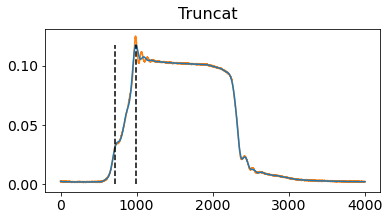


MLSi20HV7kV1Hz - Trial06 - Seg7
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.125 (bar) in 0.140 (sec)

(4000,)
0.1263043585915355
0.11772858831570253


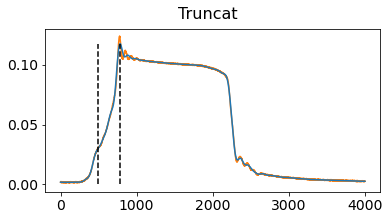


MLSi20HV7kV1Hz - Trial06 - Seg8
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.124 (bar) in 0.147 (sec)

(4000,)
0.12051469681908383
0.11476756195895475


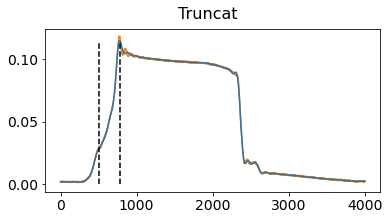


MLSi20HV7kV1Hz - Trial06 - Seg9
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.118 (bar) in 0.136 (sec)

(4000,)
0.12421943883968309
0.11545776589740347


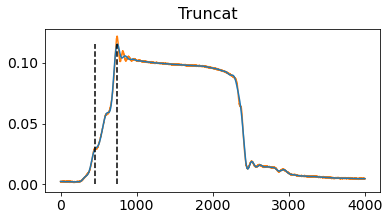


MLSi20HV7kV1Hz - Trial06 - Seg10
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.122 (bar) in 0.147 (sec)

(4000,)
0.11132501206668824
0.10724622928969897


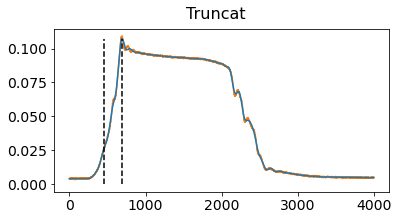


MLSi20HV7kV1Hz - Trial06 - Seg11
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.109 (bar) in 0.119 (sec)

(4000,)
0.09543150841987494
0.09193484578429953


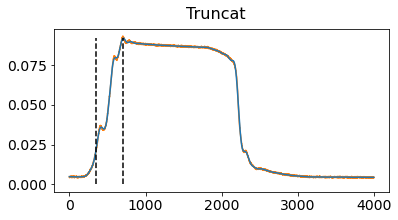


MLSi20HV7kV1Hz - Trial06 - Seg12
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.093 (bar) in 0.176 (sec)

(4000,)
0.09607302218967567
0.09331162075281589


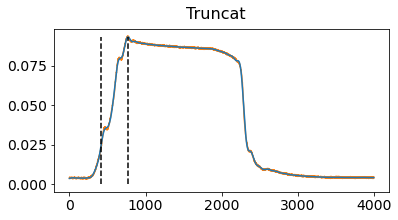


MLSi20HV7kV1Hz - Trial06 - Seg13
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.094 (bar) in 0.178 (sec)

(4000,)
0.0941805565687635
0.09198060073703518


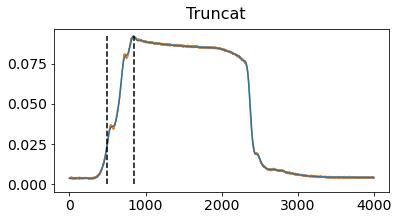


MLSi20HV7kV1Hz - Trial06 - Seg14
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.092 (bar) in 0.176 (sec)

(4000,)
0.09337866435651257
0.0910382513418533


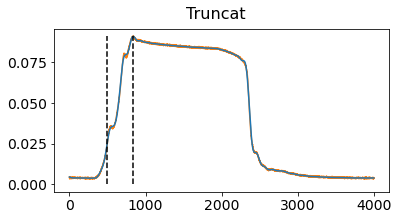


MLSi20HV7kV1Hz - Trial06 - Seg15
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.091 (bar) in 0.174 (sec)

(4000,)
0.09169469071078562
0.08912100818542411


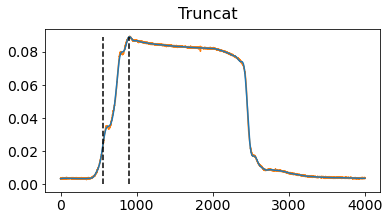


MLSi20HV7kV1Hz - Trial06 - Seg16
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.089 (bar) in 0.177 (sec)

(4000,)
0.09029939826146902
0.08794124761579648


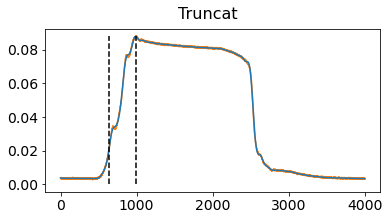


MLSi20HV7kV1Hz - Trial06 - Seg17
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.088 (bar) in 0.173 (sec)

(4000,)
0.092881491184917
0.0902997051386565


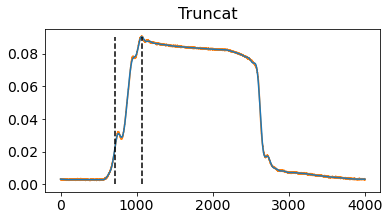


MLSi20HV7kV1Hz - Trial06 - Seg18
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.091 (bar) in 0.175 (sec)



In [5]:
'''Measurement 2022 Twenty Trial'''
pressData = []
Fs = 2000

'''
Shifted0.5s: 1-3, 5-7, 9-11, ...
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77]
'''

for root, directories, files in walk(".\data\ValidData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum, sigFreq = decodeFileName2(fileName)
                
                trialArray = np.arange(1, 40, 2.22)/sigFreq
                beginInd = (Fs * np.array(0.1 + trialArray)).astype(int)
                endInd = (Fs * np.array(0.1 + 2/sigFreq + trialArray)).astype(int)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])
                
#                 ax, _ = aPlot()
#                 ax.plot(data)
#                 ax.plot(beginInd, np.zeros(beginInd.shape), '*r')
#                 ax.plot(endInd, np.zeros(endInd.shape), '*g')
#                 plt.show()

                for i in range(len(beginInd)): 
#                     ax.plot(beginInd[i]+np.arange(len(data[beginInd[i]:endInd[i]])), data[beginInd[i]:endInd[i]])
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, 
                                                                               inactivePressure, 20, 8)
                    P0 = data[beginInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd, sigFreq]) # 1 bar = 100 kPa
                    
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex', 'SigFreq'])

# for aCondi in condiTable['CondiName']: # Drop any extra measurement more than five trials
#     allTrials = pressData[pressData['CondiName'] == aCondi]
#     trialNum = allTrials.shape[0]
#     if trialNum > 5:
#         pressData = pressData.drop(pressData[pressData['CondiName'] == aCondi].index)
#         pressData = pressData.append(allTrials.iloc[:5])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv")

In [ ]:
'''Measurement 2021'''
Fs = 1000

pressData = []
''' Process measurement data saved as individual csv files by trial '''
for root, directories, files in walk(".\data\ValidData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data, Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             data[:segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data switch three times with reversed polarity from bipolar HV Trek box '''
beginInd = ((np.array([1, 8, 15]) - 0.1) * Fs).astype(int)
endInd = ((np.array([5, 12, 19]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data driven by reversed polarity from bipolar wearable controller '''                
for root, directories, files in walk(".\data\ValidData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)
            names = re.split('U6900V', names)[0] # Shorten the names

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')     
            
            data = (data[:,1] - calib[1]) * calib[0] # Unit conversion and only keep used channel (1)
            
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data[:int(3.5*Fs)], Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             data[:segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data switch two times with reversed polarity from bipolar HV Trek box (2022) '''
beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2) 
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa
                
                
            
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex'])

for aCondi in condiTable['CondiName']: # Drop any extra measurement more than five trials
    allTrials = pressData[pressData['CondiName'] == aCondi]
    trialNum = allTrials.shape[0]
    if trialNum > 5:
        pressData = pressData.drop(pressData[pressData['CondiName'] == aCondi].index)
        pressData = pressData.append(allTrials.iloc[:5])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
# pressData.to_csv("Measurements.csv")



In [ ]:
# ax,_=aPlot()

# for i in range(5):
#     ax.plot(sigData.loc[sigData['CondiName'] == 'Mylar16NoShift','PressSig_kPa'].iloc[i])

In [7]:
sigData.head()

NameError: name 'sigData' is not defined

In [8]:
simData = pd.read_csv("./data./temp_result.csv") # Data from model simulation
simData.tail()

,CondiName,PFull_Pa,P1Expan_Pa,P2Expan_Pa,P1Cell_Pa,EsFull_J,Es1Expan_J,Es2Expan_J,Es1Cell_J,dVFull_m3,dV1Expan_m3,dV2Expan_m3,dV1Cell_m3,lossFactor
26,L0WsSi6-16Trek9kVHVTop,26660.655160,26752.465236,26823.201681,28021.234350,0.319638,0.245677,0.173914,0.010129,0.000006,0.000005,0.000003,1.807397e-07,1.098169e+08
27,L0WsSi6-16Trek10kVHVTop,32914.389087,33027.734859,33115.063804,34594.116481,0.394614,0.303305,0.214708,0.012505,0.000006,0.000005,0.000003,1.807397e-07,1.098169e+08
28,L0WsSi5-20sTrek9kVHVBot,23018.571641,23076.868762,23076.868762,24208.791110,0.276067,0.205426,0.136951,0.011963,0.000006,0.000004,0.000003,2.470741e-07,1.098169e+08
29,MLSi20HV7kV.5Hz,19818.711502,19818.711502,19740.115144,21471.036681,0.237756,0.184921,0.133962,0.010396,0.000006,0.000005,0.000003,2.421022e-07,1.098169e+08
30,MLSi20HV7kV1Hz,19818.711502,19818.711502,19740.115144,21471.036681,0.237756,0.184921,0.133962,0.010396,0.000006,0.000005,0.000003,2.421022e-07,1.098169e+08


In [9]:
''' Both Simulation and Measurement Data required '''

sigData['V0'] = 0

avgPressLoss = []
for i in sigData.index:
    deltaVolume = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'dV1Expan_m3'].iloc[0]

    sigData.loc[i,'V0'] = deltaVolume / (1 - pressData.loc[i,'P0_kPa']/pressData.loc[i,'MaxPressure_kPa']) # Unit: m3
    
    print(sigData.loc[i,'V0'])
    print(pressData.loc[i,'P0_kPa'])
    print(sigData.loc[i,'SegIndex'])
    
    print("%s inital air volume = %.6f mL" % (sigData.loc[i,'CondiName'], sigData.loc[i,'V0']*1e6)) 
    
    ''' Realtime volume '''
    Vi = sigData.loc[i,'V0'] * pressData.loc[i,'P0_kPa'] / (sigData.loc[i,'PressSig_kPa'] + 1e-3) # Unit: m3
    
    zippingVi = Vi[sigData.loc[i,'SegIndex'][0]:sigData.loc[i,'SegIndex'][1]] # Unit: m3
    
    zippingVi = lowpassFilter(zippingVi, 20, Fs, 8) # Smooth volume change before differentiation
    
    ''' Realtime volume flow rate '''
    Qi = np.diff(zippingVi) * Fs # Unit: m3/s
    
    PiLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * Qi
    
    avgPLoss = np.mean(PiLoss)*1e-3 # Unit: kPa
    print("%s avg. pressure loss = %.2f kPa" % (sigData.loc[i,'CondiName'], avgPLoss))
    avgPressLoss.append(avgPLoss)
    
#     ax,_=aPlot()
#     ax.plot(zippingVi)
# #     ax.plot(np.arange(sigData.loc[i,'SegIndex'][0], sigData.loc[i,'SegIndex'][1]), zippingVi)
# #     ax.plot([sigData.loc[i,'SegIndex'][0],sigData.loc[i,'SegIndex'][0]], [0, 6e-6], '--k')
# #     ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, 6e-6], '--k')
# # #     ax.set_ylim([0, 6e-6]);
#     ax2 = ax.twinx() 
#     ax2.plot(PiLoss,color='tab:orange')
# #     ax2.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
#     plt.show();


pressData['P1ExpanLoss_kPa'] = avgPressLoss
pressData.to_csv("Measurements.csv") 

NameError: name 'sigData' is not defined